# Experiments California Housing

In [1]:
#resets the environment
%reset -f -s 

In [2]:
import dataloader
import elm
import logger
import mlp
import utils

from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import time
import os

In [3]:
logger.warning("Tensorflow does not allow Cw specification!") #TODO

In [ ]:
# Define the name of the dataset
name_dataset = "california_housing"


# Function to save a numpy array to a csv file
def save_matrix(matrix, matrix_name, dataset_name):
    path = f"risultati/{dataset_name}/{matrix_name}.csv"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    np.savetxt(path, matrix, delimiter=",")

In [4]:
X, y = dataloader.load_california_housing()
X = X[0:10000, :]       # TODO prendo solo le prime 10000 istanze perché sennò rischia di non bastarmi la RAM
y = y[0:10000]          # TODO prendo solo le prime 10000 istanze perché sennò rischia di non bastarmi la RAM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1729)
print("Train")
print(X_train.shape)
print("\nTest")
print(X_test.shape)
X_train_mean = np.mean(X_train, axis = 0)
X_train_std = np.std(X_train,axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std
y_train_mean = np.mean(y_train)
y_train = y_train - y_train_mean
y_test = y_test - y_train_mean

Train
(7500, 8)

Test
(2500, 8)


In [5]:
# Experiments Parameters
activation = "erf"
min_n = 1
max_n = 1000
step_n = 10
n_s = np.arange(min_n, max_n, step_n)

In [6]:
# Experiments ELM with W1_star

train_error_ELM_W1_star = np.zeros(len(n_s))
test_error_ELM_W1_star = np.zeros(len(n_s))
                                                                            #TODO cronometrare 
K = elm.gen_K(X_train.T, X_train.T, activation)
_, U =  utils.sortedeigh(K)

#compute (X_train.T@X_train)^(-1) @ X_train.T
pref = np.linalg.inv(X_train.T @ X_train) @ X_train.T

for index, n in enumerate(n_s):
    W1_star = elm.get_W1_star(U, n, X_train, pref, activation)
    beta = elm.train_ELM(X_train, y_train, W1_star, activation)
    train_error_ELM_W1_star[index] = elm.evaluate(X_train, y_train, W1_star, beta, activation)
    test_error_ELM_W1_star[index] = elm.evaluate(X_test, y_test, W1_star, beta, activation)
    


INFO:logger:y_train must be centered for a correct evaluation!



In [9]:
# Experiments ELM mean error with range [min error, max error]
loops = 30
#seed = int(time.time_ns()) % 1000000
seed = 314
rng = np.random.default_rng(seed)

train_error_ELM = np.zeros((loops, len(n_s)))
test_error_ELM = np.zeros((loops, len(n_s)))

n0 = X_train.shape[1]
Cw = 1

for loop in range(loops):
    for index, n in enumerate(n_s):
        W = rng.standard_normal(size=(n0,n)) * np.sqrt(Cw/n0)
        beta = elm.train_ELM(X_train, y_train, W, activation)
        train_error_ELM[loop, index] = elm.evaluate(X_train, y_train, W, beta, activation)
        test_error_ELM[loop, index] = elm.evaluate(X_test, y_test, W, beta, activation)

train_error_ELM_mean = np.mean(train_error_ELM, axis = 0)
train_error_ELM_min = np.min(train_error_ELM, axis = 0)
train_error_ELM_max = np.max(train_error_ELM, axis = 0)
lower_errors_tr_ELM = train_error_ELM_mean - train_error_ELM_min + 1e-10
upper_errors_tr_ELM = train_error_ELM_max - train_error_ELM_mean + 1e-10

test_error_ELM_mean = np.mean(test_error_ELM, axis = 0)
test_error_ELM_min = np.min(test_error_ELM, axis = 0)
test_error_ELM_max = np.max(test_error_ELM, axis = 0)
lower_errors_te_ELM = test_error_ELM_mean - test_error_ELM_min + 1e-10
upper_errors_te_ELM = test_error_ELM_max - test_error_ELM_mean + 1e-10

In [10]:
# Experiments ELM mean error with range [min error, max error]
loops = 30

train_error_NN = np.zeros((loops, len(n_s)))
test_error_NN = np.zeros((loops, len(n_s)))

n0 = X_train.shape[1]
Cb = 0
Cw = 1
L = 1

learning_rate = 0.005
batch_size = 32
epochs = 100


for loop in range(loops):
    print(str(loop) + "/" + str(loops), sep = "\t")
    for index, n in enumerate(n_s):
        widths = [n0, n, 1]
        seeds = [int(time.time()/2), int(time.time()/3), int(time.time()/4), int(time.time()/5)]
        nn = mlp.create_mlp(widths, activation, Cb, Cw, seeds, use_bias=False)
        nn = mlp.train_mlp(nn, X_train, y_train, learning_rate, epochs, batch_size)

        train_error_NN[loop, index] = mlp.evaluate(nn, X_train, y_train)
        test_error_NN[loop, index] = mlp.evaluate(nn, X_test, y_test)

train_error_NN_mean = np.mean(train_error_NN, axis = 0)

test_error_NN_mean = np.mean(test_error_NN, axis = 0)


c:\Users\fabia\OneDrive\Desktop\ELM_Simulazioni\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\fabia\OneDrive\Desktop\ELM_Simulazioni\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\fabia\OneDrive\Desktop\ELM_Simulazioni\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in th

KeyboardInterrupt: 

In [ ]:
# Save all matrices
save_matrix(train_error_ELM_W1_star, "train_error_ELM_W1_star", name_dataset)
save_matrix(test_error_ELM_W1_star, "test_error_ELM_W1_star", name_dataset)
save_matrix(train_error_ELM, "train_error_ELM", name_dataset)
save_matrix(test_error_ELM, "test_error_ELM", name_dataset)
save_matrix(train_error_NN, "train_error_NN", name_dataset)
save_matrix(test_error_NN, "test_error_NN", name_dataset)

In [ ]:
plt.figure(1)
plt.title("Train Error - California Housing")
p11 = plt.errorbar(n_s, train_error_ELM_mean, yerr=[lower_errors_tr_ELM, upper_errors_tr_ELM], capsize=3, capthick=1, color ='blue', ecolor=(0, 0, 1, 0.5))
p12,=plt.plot(n_s,train_error_ELM_W1_star,'r-')
p13,=plt.plot(n_s,train_error_NN_mean,'g-')
plt.xlim(0,n_s[-1])
plt.xlabel("n")
plt.legend([p11, p12, p13], ["mean ELM", "ELM Wstar", "NN"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)


In [ ]:
plt.figure(2)
plt.title("Test Error - California Housing")
p21 = plt.errorbar(n_s, test_error_ELM_mean, yerr=[lower_errors_te_ELM, upper_errors_te_ELM], capsize=3, capthick=1, color ='blue', ecolor=(0, 0, 1, 0.5))
p22,=plt.plot(n_s,test_error_ELM_W1_star,'r-')
p23,=plt.plot(n_s,test_error_NN_mean,'g-')
plt.xlim(0,n_s[-1])
plt.xlabel("n")
plt.legend([p21, p22, p23], ["mean ELM", "ELM Wstar", "NN"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)


# Experiments Servo

In [31]:
#resets the environment
%reset -f -s 

In [32]:
import dataloader
import elm
import logger
import mlp
import utils

from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import time
import scipy
import os

In [33]:
logger.warning("Tensorflow does not allow Cw specification!") #TODO

In [34]:
# Define the name of the dataset
name_dataset = "servo"


# Function to save a numpy array to a csv file
def save_matrix(matrix, matrix_name, dataset_name):
    path = f"risultati/{dataset_name}/{matrix_name}.csv"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    np.savetxt(path, matrix, delimiter=",")

In [35]:
X, y = dataloader.load_servo()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1729)
print("Train")
print(X_train.shape)
print("\nTest")
print(X_test.shape)
X_train_mean = np.mean(X_train, axis = 0)
X_train_std = np.std(X_train,axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std
y_train_mean = np.mean(y_train)
y_train = y_train - y_train_mean
y_test = y_test - y_train_mean

Train
(125, 19)

Test
(42, 19)


In [36]:
# Experiments Parameters
activation = "erf"
min_n = 1
max_n = int(0.8 * X_train.shape[0])
step_n = np.maximum(1, int(max_n/100)+1)
n_s = np.arange(min_n, max_n, step_n)

print(step_n)
print(n_s[-1])
print(n_s.shape)

2
99
(50,)


In [37]:
# Experiments ELM with W1_star

train_error_ELM_W1_star = np.zeros(len(n_s))
test_error_ELM_W1_star = np.zeros(len(n_s))

K = elm.gen_K(X_train.T, X_train.T, activation)
_, U =  utils.sortedeigh(K)

#compute (X_train.T@X_train)^(-1) @ X_train.T
pref = np.linalg.inv(X_train.T @ X_train) @ X_train.T

for index, n in enumerate(n_s):
    W1_star = elm.get_W1_star(U, n, X_train, pref, activation)
    beta = elm.train_ELM((U[:,0:n]).reshape(U.shape[0], n), y_train)
#    S_train = apply_activation(X_train @ W, activation)
#    beta = elm.train_ELM(X_train, y_train, W1_star, activation)
    train_error_ELM_W1_star[index] = elm.evaluate(X_train, y_train, W1_star, beta, activation)
    test_error_ELM_W1_star[index] = elm.evaluate(X_test, y_test, W1_star, beta, activation)
    


INFO:logger:y_train must be centered for a correct evaluation!



In [38]:
# Experiments ELM mean error with range [min error, max error]
loops = 30
#seed = int(time.time_ns()) % 1000000
seed = 314
rng = np.random.default_rng(seed)

train_error_ELM = np.zeros((loops, len(n_s)))
test_error_ELM = np.zeros((loops, len(n_s)))

n0 = X_train.shape[1]
Cw = 1

for loop in range(loops):
    for index, n in enumerate(n_s):
        W = rng.standard_normal(size=(n0,n)) * np.sqrt(Cw/n0)
        beta = elm.train_ELM(scipy.special.erf(X_train @ W), y_train)
        train_error_ELM[loop, index] = elm.evaluate(X_train, y_train, W, beta, activation)
        test_error_ELM[loop, index] = elm.evaluate(X_test, y_test, W, beta, activation)

train_error_ELM_mean = np.mean(train_error_ELM, axis = 0)
train_error_ELM_min = np.min(train_error_ELM, axis = 0)
train_error_ELM_max = np.max(train_error_ELM, axis = 0)
lower_errors_tr_ELM = train_error_ELM_mean - train_error_ELM_min + 1e-10
upper_errors_tr_ELM = train_error_ELM_max - train_error_ELM_mean + 1e-10

test_error_ELM_mean = np.mean(test_error_ELM, axis = 0)
test_error_ELM_min = np.min(test_error_ELM, axis = 0)
test_error_ELM_max = np.max(test_error_ELM, axis = 0)
lower_errors_te_ELM = test_error_ELM_mean - test_error_ELM_min + 1e-10
upper_errors_te_ELM = test_error_ELM_max - test_error_ELM_mean + 1e-10

In [39]:
# Experiments ELM mean error with range [min error, max error]
loops = 30

train_error_NN = np.zeros((loops, len(n_s)))
test_error_NN = np.zeros((loops, len(n_s)))

n0 = X_train.shape[1]
Cb = 0
Cw = 1
L = 1

learning_rate = 0.005
batch_size = 32
epochs = 100


for loop in range(loops):
    print(str(loop) + "/" + str(loops))
    for index, n in enumerate(n_s):
        widths = [n0, n, 1]
        seeds = [int(time.time()/2), int(time.time()/3), int(time.time()/4), int(time.time()/5)]
        nn = mlp.create_mlp(widths, activation, Cb, Cw, seeds, use_bias=False)
        nn = mlp.train_mlp(nn, X_train, y_train, learning_rate, epochs, batch_size)

        train_error_NN[loop, index] = mlp.evaluate(nn, X_train, y_train)
        test_error_NN[loop, index] = mlp.evaluate(nn, X_test, y_test)

train_error_NN_mean = np.mean(train_error_NN, axis = 0)

test_error_NN_mean = np.mean(test_error_NN, axis = 0)


0/30


1/30
2/30
3/30
4/30
5/30
6/30
7/30
8/30
9/30
10/30
11/30
12/30
13/30
14/30
15/30
16/30
17/30
18/30
19/30
20/30
21/30
22/30
23/30
24/30
25/30
26/30
27/30
28/30
29/30


In [40]:
# Save all matrices
save_matrix(train_error_ELM_W1_star, "train_error_ELM_W1_star", name_dataset)
save_matrix(test_error_ELM_W1_star, "test_error_ELM_W1_star", name_dataset)
save_matrix(train_error_ELM, "train_error_ELM", name_dataset)
save_matrix(test_error_ELM, "test_error_ELM", name_dataset)
save_matrix(train_error_NN, "train_error_NN", name_dataset)
save_matrix(test_error_NN, "test_error_NN", name_dataset)

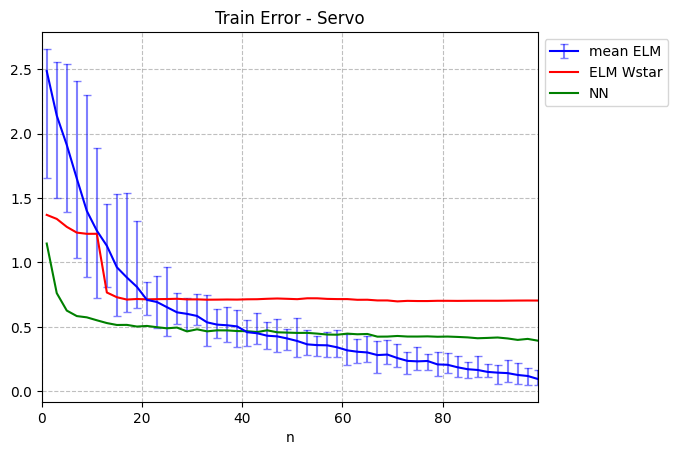

In [41]:
plt.figure(1)
plt.title("Train Error - Servo")
p11 = plt.errorbar(n_s, train_error_ELM_mean, yerr=[lower_errors_tr_ELM, upper_errors_tr_ELM], capsize=3, capthick=1, color ='blue', ecolor=(0, 0, 1, 0.5))
p12,=plt.plot(n_s,train_error_ELM_W1_star,'r-')
p13,=plt.plot(n_s,train_error_NN_mean,'g-')
plt.xlim(0,n_s[-1])
plt.xlabel("n")
plt.legend([p11, p12, p13], ["mean ELM", "ELM Wstar", "NN"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)


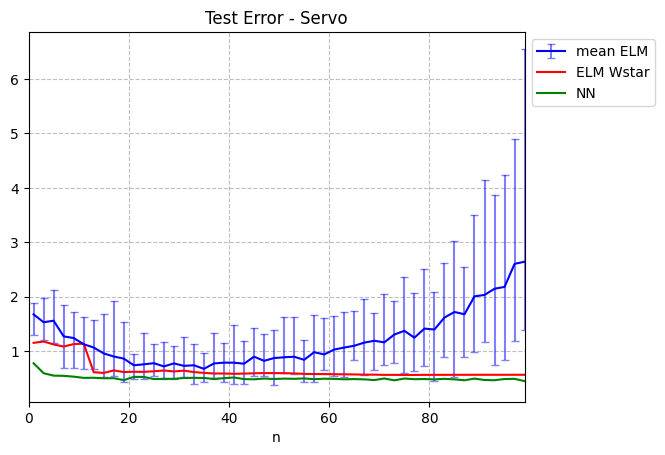

In [42]:
plt.figure(2)
plt.title("Test Error - Servo")
p21 = plt.errorbar(n_s, test_error_ELM_mean, yerr=[lower_errors_te_ELM, upper_errors_te_ELM], capsize=3, capthick=1, color ='blue', ecolor=(0, 0, 1, 0.5))
p22,=plt.plot(n_s,test_error_ELM_W1_star,'r-')
p23,=plt.plot(n_s,test_error_NN_mean,'g-')
plt.xlim(0,n_s[-1])
plt.xlabel("n")
plt.legend([p21, p22, p23], ["mean ELM", "ELM Wstar", "NN"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

# Experiments Auto MPG

In [43]:
#resets the environment
%reset -f -s 

In [44]:
import dataloader
import elm
import logger
import mlp
import utils

from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import time
import scipy
import os

In [45]:
logger.warning("Tensorflow does not allow Cw specification!") #TODO

In [46]:
# Define the name of the dataset
name_dataset = "auto_mpg"


# Function to save a numpy array to a csv file
def save_matrix(matrix, matrix_name, dataset_name):
    path = f"risultati/{dataset_name}/{matrix_name}.csv"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    np.savetxt(path, matrix, delimiter=",")

In [47]:
X, y = dataloader.load_auto_mpg()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1729)
print("Train")
print(X_train.shape)
print("\nTest")
print(X_test.shape)
X_train_mean = np.mean(X_train, axis = 0)
X_train_std = np.std(X_train,axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std
y_train_mean = np.mean(y_train)
y_train = y_train - y_train_mean
y_test = y_test - y_train_mean

Train
(294, 21)

Test
(98, 21)


In [48]:
# Experiments Parameters
activation = "erf"
min_n = 1
max_n = int(0.8 * X_train.shape[0])
step_n = np.maximum(1, int(max_n/100)+1)
n_s = np.arange(min_n, max_n, step_n)

print(step_n)
print(n_s[-1])
print(n_s.shape)

3
232
(78,)


In [49]:
# Experiments ELM with W1_star

train_error_ELM_W1_star = np.zeros(len(n_s))
test_error_ELM_W1_star = np.zeros(len(n_s))

K = elm.gen_K(X_train.T, X_train.T, activation)
_, U =  utils.sortedeigh(K)

#compute (X_train.T@X_train)^(-1) @ X_train.T
pref = np.linalg.inv(X_train.T @ X_train) @ X_train.T

for index, n in enumerate(n_s):
    W1_star = elm.get_W1_star(U, n, X_train, pref, activation)
    beta = elm.train_ELM((U[:,0:n]).reshape(U.shape[0], n), y_train)
    train_error_ELM_W1_star[index] = elm.evaluate(X_train, y_train, W1_star, beta, activation)
    test_error_ELM_W1_star[index] = elm.evaluate(X_test, y_test, W1_star, beta, activation)
    


In [50]:
# Experiments ELM mean error with range [min error, max error]
loops = 30
#seed = int(time.time_ns()) % 1000000
seed = 314
rng = np.random.default_rng(seed)

train_error_ELM = np.zeros((loops, len(n_s)))
test_error_ELM = np.zeros((loops, len(n_s)))

n0 = X_train.shape[1]
Cw = 1

for loop in range(loops):
    for index, n in enumerate(n_s):
        W = rng.standard_normal(size=(n0,n)) * np.sqrt(Cw/n0)
        beta = elm.train_ELM(scipy.special.erf(X_train @ W), y_train)
        train_error_ELM[loop, index] = elm.evaluate(X_train, y_train, W, beta, activation)
        test_error_ELM[loop, index] = elm.evaluate(X_test, y_test, W, beta, activation)

train_error_ELM_mean = np.mean(train_error_ELM, axis = 0)
train_error_ELM_min = np.min(train_error_ELM, axis = 0)
train_error_ELM_max = np.max(train_error_ELM, axis = 0)
lower_errors_tr_ELM = train_error_ELM_mean - train_error_ELM_min + 1e-10
upper_errors_tr_ELM = train_error_ELM_max - train_error_ELM_mean + 1e-10

test_error_ELM_mean = np.mean(test_error_ELM, axis = 0)
test_error_ELM_min = np.min(test_error_ELM, axis = 0)
test_error_ELM_max = np.max(test_error_ELM, axis = 0)
lower_errors_te_ELM = test_error_ELM_mean - test_error_ELM_min + 1e-10
upper_errors_te_ELM = test_error_ELM_max - test_error_ELM_mean + 1e-10

In [51]:
# Experiments ELM mean error with range [min error, max error]
loops = 30

train_error_NN = np.zeros((loops, len(n_s)))
test_error_NN = np.zeros((loops, len(n_s)))

n0 = X_train.shape[1]
Cb = 0
Cw = 1
L = 1

learning_rate = 0.005
batch_size = 32
epochs = 100


for loop in range(loops):
    print(str(loop) + "/" + str(loops))
    for index, n in enumerate(n_s):
        widths = [n0, n, 1]
        seeds = [int(time.time()/2), int(time.time()/3), int(time.time()/4), int(time.time()/5)]
        nn = mlp.create_mlp(widths, activation, Cb, Cw, seeds, use_bias=False)
        nn = mlp.train_mlp(nn, X_train, y_train, learning_rate, epochs, batch_size)

        train_error_NN[loop, index] = mlp.evaluate(nn, X_train, y_train)
        test_error_NN[loop, index] = mlp.evaluate(nn, X_test, y_test)

train_error_NN_mean = np.mean(train_error_NN, axis = 0)

test_error_NN_mean = np.mean(test_error_NN, axis = 0)


0/30
1/30
2/30
3/30
4/30
5/30
6/30
7/30
8/30
9/30
10/30
11/30
12/30
13/30
14/30
15/30
16/30
17/30
18/30
19/30
20/30
21/30
22/30
23/30
24/30
25/30
26/30
27/30
28/30
29/30


In [52]:
# Save all matrices
save_matrix(train_error_ELM_W1_star, "train_error_ELM_W1_star", name_dataset)
save_matrix(test_error_ELM_W1_star, "test_error_ELM_W1_star", name_dataset)
save_matrix(train_error_ELM, "train_error_ELM", name_dataset)
save_matrix(test_error_ELM, "test_error_ELM", name_dataset)
save_matrix(train_error_NN, "train_error_NN", name_dataset)
save_matrix(test_error_NN, "test_error_NN", name_dataset)

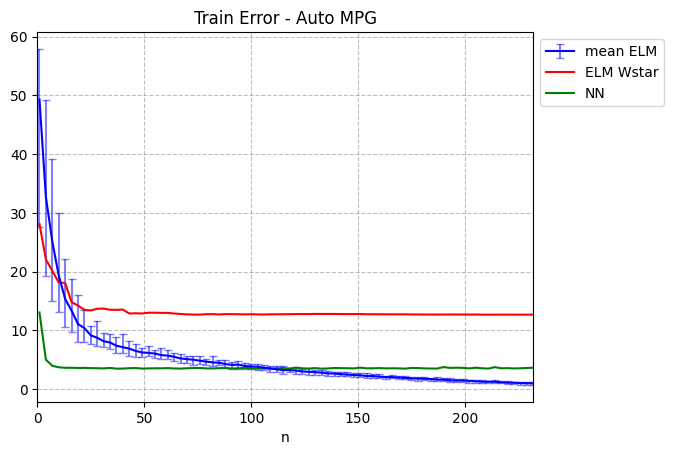

In [53]:
plt.figure(1)
plt.title("Train Error - Auto MPG")
p11 = plt.errorbar(n_s, train_error_ELM_mean, yerr=[lower_errors_tr_ELM, upper_errors_tr_ELM], capsize=3, capthick=1, color ='blue', ecolor=(0, 0, 1, 0.5))
p12,=plt.plot(n_s,train_error_ELM_W1_star,'r-')
p13,=plt.plot(n_s,train_error_NN_mean,'g-')
plt.xlim(0,n_s[-1])
plt.xlabel("n")
plt.legend([p11, p12, p13], ["mean ELM", "ELM Wstar", "NN"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)


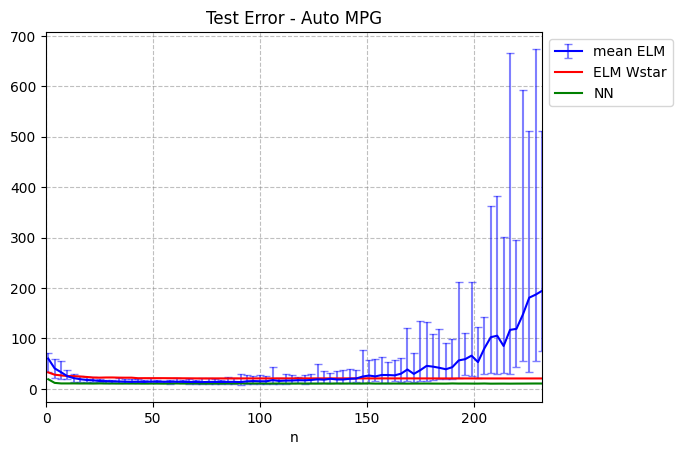

In [54]:
plt.figure(2)
plt.title("Test Error - Auto MPG")
p21 = plt.errorbar(n_s, test_error_ELM_mean, yerr=[lower_errors_te_ELM, upper_errors_te_ELM], capsize=3, capthick=1, color ='blue', ecolor=(0, 0, 1, 0.5))
p22,=plt.plot(n_s,test_error_ELM_W1_star,'r-')
p23,=plt.plot(n_s,test_error_NN_mean,'g-')
plt.xlim(0,n_s[-1])
plt.xlabel("n")
plt.legend([p21, p22, p23], ["mean ELM", "ELM Wstar", "NN"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

# Experiments Machine CPU

In [55]:
#resets the environment
%reset -f -s 

In [56]:
import dataloader
import elm
import logger
import mlp
import utils

from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import time
import scipy
import os

In [57]:
logger.warning("Tensorflow does not allow Cw specification!") #TODO

In [58]:
# Define the name of the dataset
name_dataset = "machine_cpu"


# Function to save a numpy array to a csv file
def save_matrix(matrix, matrix_name, dataset_name):
    path = f"risultati/{dataset_name}/{matrix_name}.csv"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    np.savetxt(path, matrix, delimiter=",")

In [59]:
X, y = dataloader.load_machine_cpu()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1729)
print("Train")
print(X_train.shape)
print("\nTest")
print(X_test.shape)
X_train_mean = np.mean(X_train, axis = 0)
X_train_std = np.std(X_train,axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std
y_train_mean = np.mean(y_train)
y_train = y_train - y_train_mean
y_test = y_test - y_train_mean

Train
(156, 6)

Test
(53, 6)


In [60]:
# Experiments Parameters
activation = "erf"
min_n = 1
max_n = int(0.8 * X_train.shape[0])
step_n = np.maximum(1, int(max_n/100)+1)
n_s = np.arange(min_n, max_n, step_n)

print(step_n)
print(n_s[-1])
print(n_s.shape)

2
123
(62,)


In [61]:
# Experiments ELM with W1_star

train_error_ELM_W1_star = np.zeros(len(n_s))
test_error_ELM_W1_star = np.zeros(len(n_s))

K = elm.gen_K(X_train.T, X_train.T, activation)
L, U =  utils.sortedeigh(K)

#compute (X_train.T@X_train)^(-1) @ X_train.T
pref = np.linalg.inv(X_train.T @ X_train) @ X_train.T

for index, n in enumerate(n_s):
    W1_star = elm.get_W1_star(U, n, X_train, pref, activation)
    beta = elm.train_ELM((U[:,0:n]).reshape(U.shape[0], n), y_train)
#    beta = elm.train_ELM(X_train, y_train, W1_star, activation)
    train_error_ELM_W1_star[index] = elm.evaluate(X_train, y_train, W1_star, beta, activation)
    test_error_ELM_W1_star[index] = elm.evaluate(X_test, y_test, W1_star, beta, activation)
    


In [62]:
# Experiments ELM mean error with range [min error, max error]
loops = 30
#seed = int(time.time_ns()) % 1000000
seed = 314
rng = np.random.default_rng(seed)

train_error_ELM = np.zeros((loops, len(n_s)))
test_error_ELM = np.zeros((loops, len(n_s)))

n0 = X_train.shape[1]
Cw = 1

for loop in range(loops):
    for index, n in enumerate(n_s):
        W = rng.standard_normal(size=(n0,n)) * np.sqrt(Cw/n0)
        beta = elm.train_ELM(scipy.special.erf(X_train @ W), y_train)
        train_error_ELM[loop, index] = elm.evaluate(X_train, y_train, W, beta, activation)
        test_error_ELM[loop, index] = elm.evaluate(X_test, y_test, W, beta, activation)

train_error_ELM_mean = np.mean(train_error_ELM, axis = 0)
train_error_ELM_min = np.min(train_error_ELM, axis = 0)
train_error_ELM_max = np.max(train_error_ELM, axis = 0)
lower_errors_tr_ELM = train_error_ELM_mean - train_error_ELM_min + 1e-10
upper_errors_tr_ELM = train_error_ELM_max - train_error_ELM_mean + 1e-10

test_error_ELM_mean = np.mean(test_error_ELM, axis = 0)
test_error_ELM_min = np.min(test_error_ELM, axis = 0)
test_error_ELM_max = np.max(test_error_ELM, axis = 0)
lower_errors_te_ELM = test_error_ELM_mean - test_error_ELM_min + 1e-10
upper_errors_te_ELM = test_error_ELM_max - test_error_ELM_mean + 1e-10

In [63]:
# Experiments ELM mean error with range [min error, max error]
loops = 30

train_error_NN = np.zeros((loops, len(n_s)))
test_error_NN = np.zeros((loops, len(n_s)))

n0 = X_train.shape[1]
Cb = 0
Cw = 1
L = 1

learning_rate = 0.005
batch_size = 32
epochs = 100


for loop in range(loops):
    print(str(loop) + "/" + str(loops))
    for index, n in enumerate(n_s):
        widths = [n0, n, 1]
        seeds = [int(time.time()/2), int(time.time()/3), int(time.time()/4), int(time.time()/5)]
        nn = mlp.create_mlp(widths, activation, Cb, Cw, seeds, use_bias=False)
        nn = mlp.train_mlp(nn, X_train, y_train, learning_rate, epochs, batch_size)

        train_error_NN[loop, index] = mlp.evaluate(nn, X_train, y_train)
        test_error_NN[loop, index] = mlp.evaluate(nn, X_test, y_test)

train_error_NN_mean = np.mean(train_error_NN, axis = 0)

test_error_NN_mean = np.mean(test_error_NN, axis = 0)


0/30
1/30
2/30
3/30
4/30
5/30
6/30
7/30
8/30
9/30
10/30
11/30
12/30
13/30
14/30
15/30
16/30
17/30
18/30
19/30
20/30
21/30
22/30
23/30
24/30
25/30
26/30
27/30
28/30
29/30


In [64]:
# Save all matrices
save_matrix(train_error_ELM_W1_star, "train_error_ELM_W1_star", name_dataset)
save_matrix(test_error_ELM_W1_star, "test_error_ELM_W1_star", name_dataset)
save_matrix(train_error_ELM, "train_error_ELM", name_dataset)
save_matrix(test_error_ELM, "test_error_ELM", name_dataset)
save_matrix(train_error_NN, "train_error_NN", name_dataset)
save_matrix(test_error_NN, "test_error_NN", name_dataset)

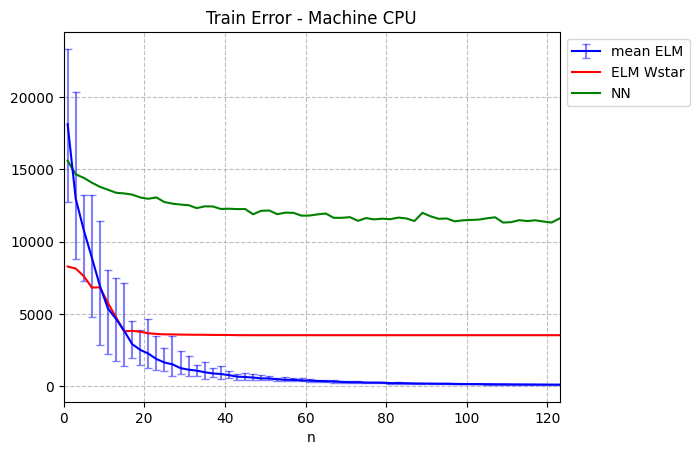

In [65]:
plt.figure(1)
plt.title("Train Error - Machine CPU")
p11 = plt.errorbar(n_s, train_error_ELM_mean, yerr=[lower_errors_tr_ELM, upper_errors_tr_ELM], capsize=3, capthick=1, color ='blue', ecolor=(0, 0, 1, 0.5))
p12,=plt.plot(n_s,train_error_ELM_W1_star,'r-')
p13,=plt.plot(n_s,train_error_NN_mean,'g-')
plt.xlim(0,n_s[-1])
plt.xlabel("n")
plt.legend([p11, p12, p13], ["mean ELM", "ELM Wstar", "NN"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)


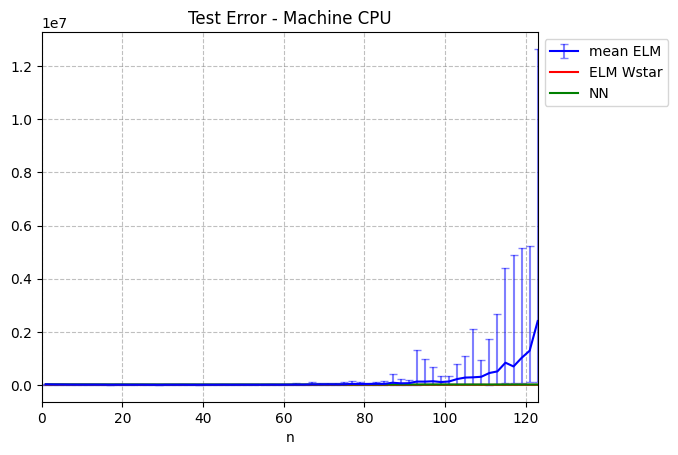

In [66]:
plt.figure(2)
plt.title("Test Error - Machine CPU")
p21 = plt.errorbar(n_s, test_error_ELM_mean, yerr=[lower_errors_te_ELM, upper_errors_te_ELM], capsize=3, capthick=1, color ='blue', ecolor=(0, 0, 1, 0.5))
p22,=plt.plot(n_s,test_error_ELM_W1_star,'r-')
p23,=plt.plot(n_s,test_error_NN_mean,'g-')
plt.xlim(0,n_s[-1])
plt.xlabel("n")
plt.legend([p21, p22, p23], ["mean ELM", "ELM Wstar", "NN"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

# Experiments Delta Ailerons

In [67]:
#resets the environment
%reset -f -s 

In [68]:
import dataloader
import elm
import logger
import mlp
import utils

from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import time
import os
import scipy

In [69]:
logger.warning("Tensorflow does not allow Cw specification!") #TODO

In [70]:
# Define the name of the dataset
name_dataset = "delta_ailerons"


# Function to save a numpy array to a csv file
def save_matrix(matrix, matrix_name, dataset_name):
    path = f"risultati/{dataset_name}/{matrix_name}.csv"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    np.savetxt(path, matrix, delimiter=",")

In [71]:
X, y = dataloader.load_delta_ailerons()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1729)
print("Train")
print(X_train.shape)
print("\nTest")
print(X_test.shape)
X_train_mean = np.mean(X_train, axis = 0)
X_train_std = np.std(X_train,axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std
y_train_mean = np.mean(y_train)
y_train = y_train - y_train_mean
y_test = y_test - y_train_mean

Train
(5346, 5)

Test
(1783, 5)


In [72]:
# Experiments Parameters
activation = "erf"
min_n = 1
max_n = np.minimum(int(0.8 * X_train.shape[0]), 999)
step_n = np.maximum(1, int(max_n/100)+1)
n_s = np.arange(min_n, max_n, step_n)

print(step_n)
print(n_s[-1])
print(n_s.shape)

10
991
(100,)


In [73]:
# Experiments ELM with W1_star

train_error_ELM_W1_star = np.zeros(len(n_s))
test_error_ELM_W1_star = np.zeros(len(n_s))

K = elm.gen_K(X_train.T, X_train.T, activation)
_, U =  utils.sortedeigh(K)

#compute (X_train.T@X_train)^(-1) @ X_train.T
pref = np.linalg.inv(X_train.T @ X_train) @ X_train.T

for index, n in enumerate(n_s):
    W1_star = elm.get_W1_star(U, n, X_train, pref, activation)
    beta = elm.train_ELM((U[:,0:n]).reshape(U.shape[0], n), y_train)
#    beta = elm.train_ELM(X_train, y_train, W1_star, activation)
    train_error_ELM_W1_star[index] = elm.evaluate(X_train, y_train, W1_star, beta, activation)
    test_error_ELM_W1_star[index] = elm.evaluate(X_test, y_test, W1_star, beta, activation)
    


In [74]:
# Experiments ELM mean error with range [min error, max error]
loops = 30
#seed = int(time.time_ns()) % 1000000
seed = 314
rng = np.random.default_rng(seed)

train_error_ELM = np.zeros((loops, len(n_s)))
test_error_ELM = np.zeros((loops, len(n_s)))

n0 = X_train.shape[1]
Cw = 1

for loop in range(loops):
    for index, n in enumerate(n_s):
        W = rng.standard_normal(size=(n0,n)) * np.sqrt(Cw/n0)
        beta = elm.train_ELM(scipy.special.erf(X_train @ W), y_train)
        train_error_ELM[loop, index] = elm.evaluate(X_train, y_train, W, beta, activation)
        test_error_ELM[loop, index] = elm.evaluate(X_test, y_test, W, beta, activation)

train_error_ELM_mean = np.mean(train_error_ELM, axis = 0)
train_error_ELM_min = np.min(train_error_ELM, axis = 0)
train_error_ELM_max = np.max(train_error_ELM, axis = 0)
lower_errors_tr_ELM = train_error_ELM_mean - train_error_ELM_min + 1e-10
upper_errors_tr_ELM = train_error_ELM_max - train_error_ELM_mean + 1e-10

test_error_ELM_mean = np.mean(test_error_ELM, axis = 0)
test_error_ELM_min = np.min(test_error_ELM, axis = 0)
test_error_ELM_max = np.max(test_error_ELM, axis = 0)
lower_errors_te_ELM = test_error_ELM_mean - test_error_ELM_min + 1e-10
upper_errors_te_ELM = test_error_ELM_max - test_error_ELM_mean + 1e-10

In [75]:
# Experiments ELM mean error with range [min error, max error]
loops = 5

train_error_NN = np.zeros((loops, len(n_s)))
test_error_NN = np.zeros((loops, len(n_s)))

n0 = X_train.shape[1]
Cb = 0
Cw = 1
L = 1

learning_rate = 0.005
batch_size = 32
epochs = 100


for loop in range(loops):
    print(str(loop) + "/" + str(loops))
    for index, n in enumerate(n_s):
        widths = [n0, n, 1]
        seeds = [int(time.time()/2), int(time.time()/3), int(time.time()/4), int(time.time()/5)]
        nn = mlp.create_mlp(widths, activation, Cb, Cw, seeds, use_bias=False)
        nn = mlp.train_mlp(nn, X_train, y_train, learning_rate, epochs, batch_size)

        train_error_NN[loop, index] = mlp.evaluate(nn, X_train, y_train)
        test_error_NN[loop, index] = mlp.evaluate(nn, X_test, y_test)

train_error_NN_mean = np.mean(train_error_NN, axis = 0)

test_error_NN_mean = np.mean(test_error_NN, axis = 0)


0/5
1/5
2/5
3/5
4/5


In [76]:
# Save all matrices
save_matrix(train_error_ELM_W1_star, "train_error_ELM_W1_star", name_dataset)
save_matrix(test_error_ELM_W1_star, "test_error_ELM_W1_star", name_dataset)
save_matrix(train_error_ELM, "train_error_ELM", name_dataset)
save_matrix(test_error_ELM, "test_error_ELM", name_dataset)
save_matrix(train_error_NN, "train_error_NN", name_dataset)
save_matrix(test_error_NN, "test_error_NN", name_dataset)

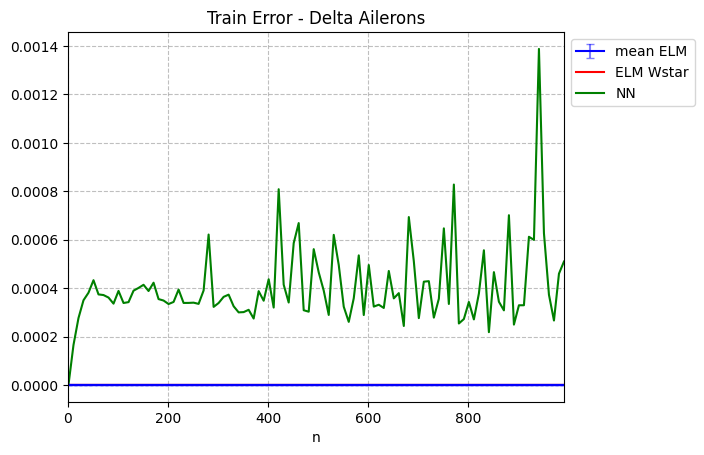

In [77]:
plt.figure(1)
plt.title("Train Error - Delta Ailerons")
p11 = plt.errorbar(n_s, train_error_ELM_mean, yerr=[lower_errors_tr_ELM, upper_errors_tr_ELM], capsize=3, capthick=1, color ='blue', ecolor=(0, 0, 1, 0.5))
p12,=plt.plot(n_s,train_error_ELM_W1_star,'r-')
p13,=plt.plot(n_s,train_error_NN_mean,'g-')
plt.xlim(0,n_s[-1])
plt.xlabel("n")
plt.legend([p11, p12, p13], ["mean ELM", "ELM Wstar", "NN"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)


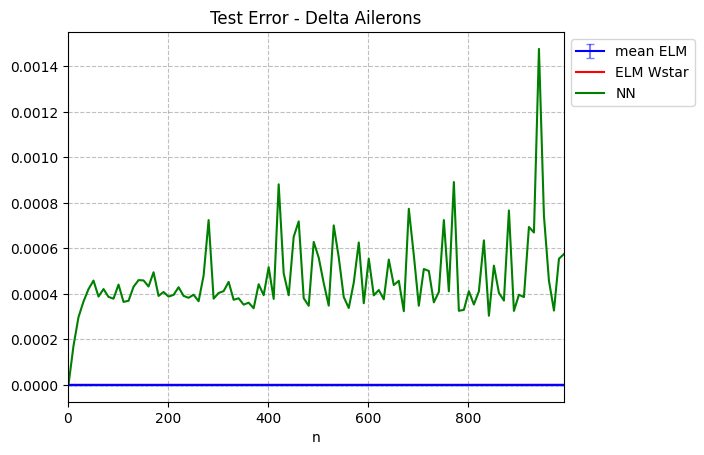

In [78]:
plt.figure(2)
plt.title("Test Error - Delta Ailerons")
p21 = plt.errorbar(n_s, test_error_ELM_mean, yerr=[lower_errors_te_ELM, upper_errors_te_ELM], capsize=3, capthick=1, color ='blue', ecolor=(0, 0, 1, 0.5))
p22,=plt.plot(n_s,test_error_ELM_W1_star,'r-')
p23,=plt.plot(n_s,test_error_NN_mean,'g-')
plt.xlim(0,n_s[-1])
plt.xlabel("n")
plt.legend([p21, p22, p23], ["mean ELM", "ELM Wstar", "NN"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

# Cianfrusaglie

In [97]:
#resets the environment
%reset -f -s 

In [98]:
import dataloader
import elm
import logger
import mlp
import utils

from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import time
import scipy

In [99]:
# Load X_train
with open('X_train.npy', 'rb') as f:
    X_train = np.load(f)

# Load X_test
with open('X_test.npy', 'rb') as f:
    X_test = np.load(f)

# Load y_train
with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)

# Load y_test
with open('y_test.npy', 'rb') as f:
    y_test = np.load(f)

In [100]:
print("Train")
print(X_train.shape)
print("\nTest")
print(X_test.shape)
X_train_mean = np.mean(X_train, axis = 0)
X_train_std = np.std(X_train,axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std
y_train_mean = np.mean(y_train)
y_train = y_train - y_train_mean
y_test = y_test - y_train_mean

activation = "erf"
n_s = np.insert(np.arange(1, 701, 10), 0, 0)

Train
(800, 50)

Test
(100, 50)


In [109]:
# Experiments ELM with W1_star

train_error_ELM_W1_star = np.zeros(len(n_s))
test_error_ELM_W1_star = np.zeros(len(n_s))
train_error2 = np.zeros(len(n_s))
test_error2 = np.zeros(len(n_s))
K = elm.gen_K(X_train.T, X_train.T, activation)
_, U =  utils.sortedeigh(K)

train_error3 = np.zeros(len(n_s))

#compute (X_train.T@X_train)^(-1) @ X_train.T
pref = np.linalg.inv(X_train.T @ X_train) @ X_train.T

for index, n in enumerate(n_s):
    W1_star = elm.get_W1_star(U, n, X_train, pref, activation)
    beta = elm.train_ELM((U[:,0:n]).reshape(U.shape[0], n), y_train)
    betaStar = elm.train_ELM(scipy.special.erf(X_train @ W1_star).reshape(U.shape[0], n), y_train)

#    beta = elm.train_ELM(X_train, y_train, W1_star, activation)
    train_error_ELM_W1_star[index] = np.mean((U[:,0:n] @ beta - y_train)**2)
    train_error2[index] = np.mean((scipy.special.erf(X_train @ W1_star).reshape(U.shape[0], n) @ betaStar - y_train)**2)
    train_error3[index] = np.mean((scipy.special.erf(X_train @ W1_star).reshape(U.shape[0], n) @ beta - y_train)**2)
    #train_error_ELM_W1_star[index] = elm.evaluate(X_train, y_train, W1_star, beta, activation)
    test_error_ELM_W1_star[index] = elm.evaluate(X_test, y_test, W1_star, beta, activation)

    test_error2[index] = elm.evaluate(X_test, y_test, W1_star, betaStar, activation)
    


In [102]:
a = np.mean(scipy.special.erf(X_train @ W1_star), axis = 0)

In [70]:
len(a)

691

In [103]:
print(a[0:10])
print(a[45:55])
print(a[600:610])

[-3.31114953e-07 -1.06336850e-06  2.63757011e-07  8.71692981e-07
  2.31320097e-07 -1.89992722e-06 -1.58333617e-06  3.39907598e-08
 -1.24906174e-06  2.49176499e-06]
[ 1.21346497e-06  7.23723276e-07  1.00768795e-07  5.42459694e-07
  8.90870239e-07  2.93198208e-11  5.46110413e-11  8.09802186e-11
  6.15779968e-11 -1.77781417e-10]
[-5.36952459e-11  5.22825752e-11 -2.85781427e-11 -4.63396458e-11
  3.46533734e-11  2.61004306e-11  2.81135648e-11 -3.11387654e-11
 -1.23173245e-11 -5.12514874e-11]


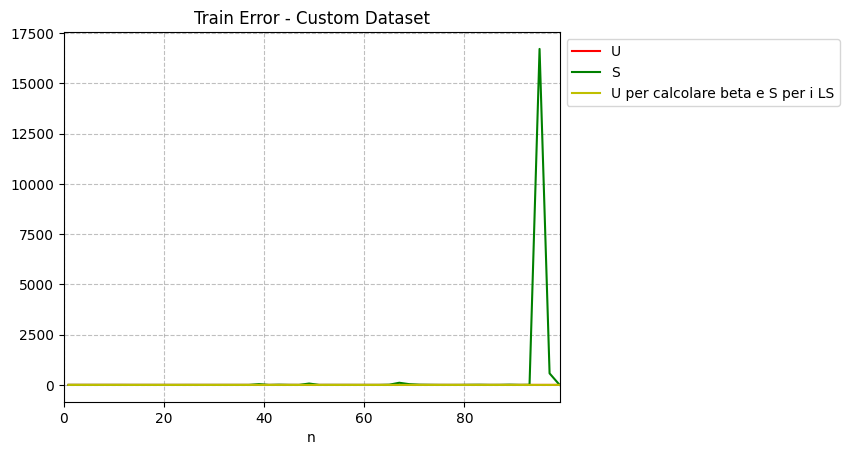

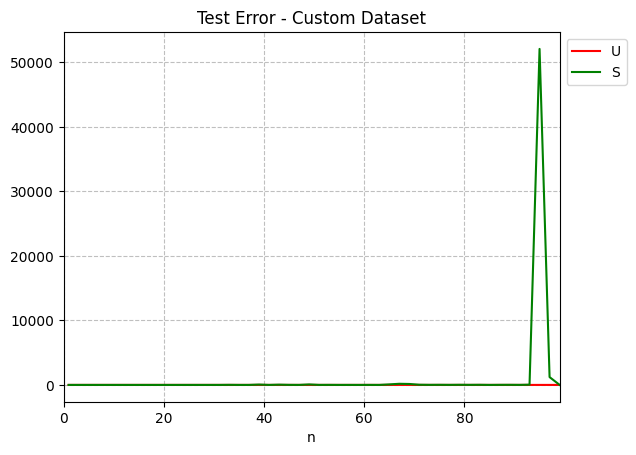

In [110]:
plt.figure(1)
plt.title("Train Error - Custom Dataset")
p12,=plt.plot(n_s,train_error_ELM_W1_star,'r-')
p13,=plt.plot(n_s,train_error2,'g-')
p14,=plt.plot(n_s,train_error3,'y-')
plt.xlim(0,n_s[-1])
plt.xlabel("n")
plt.legend([p12, p13, p14], ["U", "S", "U per calcolare beta e S per i LS"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

plt.figure(2)
plt.title("Test Error - Custom Dataset")
p22,=plt.plot(n_s,test_error_ELM_W1_star,'r-')
p23,=plt.plot(n_s,test_error2,'g-')
plt.xlim(0,n_s[-1])
plt.xlabel("n")
plt.legend([p22, p23], ["U", "S"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

In [71]:
np.argmin(test_error_ELM_W1_star)

5

In [72]:
test_error_ELM_W1_star[0:10]

array([0.12637158, 0.12674138, 0.09467799, 0.07910427, 0.07742905,
       0.06492491, 0.06528248, 0.06530785, 0.06532607, 0.06537084])

In [ ]:
L, U =  utils.sortedeigh(K)

In [ ]:
A = U[:, 0:1]
print(A.shape)

(294, 1)


In [ ]:
import math
from scipy.special import erf, erfinv

In [58]:

def f(X_train,X_test,y_train,y_test):

  _X_train_mean = np.mean(X_train, axis = 0)
  _X_train_std = np.std(X_train,axis=0)
  _X_train_non_standardizzato = X_train
  _X_test_non_standardizzato = X_test
  _X_train = (X_train - _X_train_mean) / _X_train_std
  _X_test = (X_test - _X_train_mean) / _X_train_std
  y_train_mean = np.mean(y_train)
  Tr = 800
  activation = "erf"
  x_axis_values = np.insert(np.arange(1, 701, 10), 0, 0)

  def sortedeigh(matrix):
    D,U = np.linalg.eigh(matrix)
    sortedIndices = np.argsort(D)[::-1]
    sortedD = D[sortedIndices]
    sortedU = U[:, sortedIndices]
    return sortedD, sortedU

  def gen_K(A,B, act = "relu"):
      normA = np.sqrt(np.sum(A**2,axis=0))
      normB = np.sqrt(np.sum(B**2,axis=0))

      AB = A.T @ B
      angle_AB = np.minimum( (1/normA).reshape((len(normA),1)) * AB * (1/normB).reshape( (1,len(normB)) ) ,1.)

      if act=="relu":
          K = 1/(2*math.pi)* normA.reshape((len(normA),1)) * (angle_AB*np.arccos(-angle_AB)+np.sqrt(1-angle_AB**2)) * normB.reshape( (1,len(normB)) )
      elif act =="erf":
          K = 2/math.pi*np.arcsin(2*AB/np.sqrt((1+2*(normA**2).reshape((len(normA),1)))*(1+2*(normB**2).reshape((1,len(normB))))))
      return K

  # Training error direzioni principali di K
  train_error_inf = np.zeros(Tr+1)
  score_inf = np.zeros(Tr+1)
  K_inf = gen_K(X_train.T, X_train.T, activation)
  Lambda_inf, U_inf = sortedeigh(K_inf)
  y_train_pred_inf = np.ones(Tr) * np.mean(y_train)
  r_inf = y_train - y_train_pred_inf
  num_eigenvec_used_inf = 0
  train_error_inf[num_eigenvec_used_inf] = np.mean((y_train - y_train_pred_inf)**2)
    #score_inf[num_eigenvec_used_inf] = train_error_inf[num_eigenvec_used_inf] + (num_eigenvec_used_inf * np.log(Tr)) * (train_error_inf[0] / Tr / np.log(Tr))
  dotprod = U_inf.T @ (y_train-y_train_mean)
  print(dotprod.shape)
  weightvecprod = np.zeros((Tr, Tr))
  for i in range(Tr):
    weightvecprod[:,i] = dotprod[i] * U_inf[:,i]
  y_train_pred_eigenvalues = np.cumsum(weightvecprod, axis=1)[:,0:Tr]
  train_error_inf[1:] += 1/Tr * np.linalg.norm(y_train.reshape(y_train.shape[0],1) - y_train_pred_eigenvalues - y_train_mean, axis = 0)**2
  num_eigenvec_used_inf = Tr

  print("Inizio calcoli per ELM con Wstar")
  timer_start = time.time()
  #Training e test error con ELM con Wstar
  train_error_ELM_Wstar = np.zeros(x_axis_values.shape[0])
  test_error_ELM_Wstar = np.zeros(x_axis_values.shape[0])
  train_error_ELM_Wstar[0] = np.mean((y_train - np.mean(y_train))**2)
  test_error_ELM_Wstar[0] = np.mean((y_test - np.mean(y_train))**2)
  #compute (X_train.T@X_train)^(-1) @ X_train.T
  pref = np.linalg.inv(_X_train.T @ _X_train) @ _X_train.T
  for index, n in enumerate(x_axis_values[1:]):
    S_train_Wstar = U_inf[:, 0:n+1].reshape(K_inf.shape[0], n+1)
    W_star = pref @ erfinv(S_train_Wstar)
    #S_train_Wstar = erf(_X_train @ W_star)      #QUESTO GENERA L'ERRORE
    S_test_Wstar = erf(_X_test @ W_star)
    beta_Wstar = np.linalg.inv(S_train_Wstar.T @ S_train_Wstar) @ S_train_Wstar.T @ (y_train - y_train_mean)
    y_test_pred_Wstar = S_test_Wstar @ beta_Wstar + y_train_mean
    train_error_ELM_Wstar[index + 1] = np.mean((y_train - (S_train_Wstar @ beta_Wstar + y_train_mean))**2)
    test_error_ELM_Wstar[index+1] = np.mean((y_test - y_test_pred_Wstar)**2)
  time_elapsed = time.time() - timer_start
  print("Calcoli per ELM con Wstar terminati in {} min e {} sec".format(int(time_elapsed//60), int(time_elapsed%60)))
  return train_error_ELM_Wstar, test_error_ELM_Wstar

In [59]:
import math
from scipy.special import erf, erfinv
train_error_ELM, test_error_ELM = f(X_train, X_test, y_train, y_test)

(800, 1)
Inizio calcoli per ELM con Wstar
Calcoli per ELM con Wstar terminati in 0 min e 1 sec


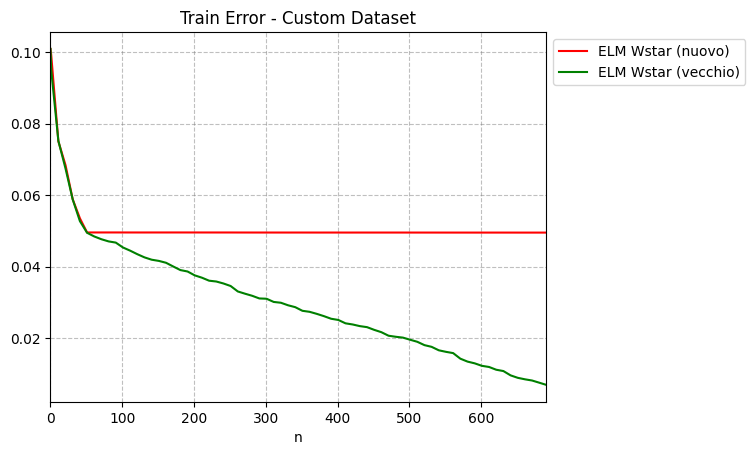

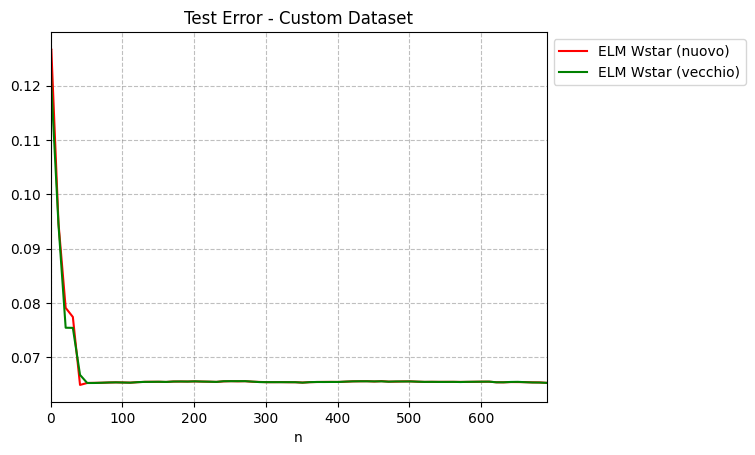

In [60]:
plt.figure(1)
plt.title("Train Error - Custom Dataset")
p12,=plt.plot(n_s,train_error_ELM_W1_star,'r-')
p13,=plt.plot(n_s,train_error_ELM,'g-')
plt.xlim(0,n_s[-1])
plt.xlabel("n")
plt.legend([p12, p13], ["ELM Wstar (nuovo)", "ELM Wstar (vecchio)"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

plt.figure(2)
plt.title("Test Error - Custom Dataset")
p22,=plt.plot(n_s,test_error_ELM_W1_star,'r-')
p23,=plt.plot(n_s,test_error_ELM,'g-')
plt.xlim(0,n_s[-1])
plt.xlabel("n")
plt.legend([p22, p23], ["ELM Wstar (nuovo)", "ELM Wstar (vecchio)"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

In [ ]:
L, U = utils.sortedeigh(K)
print(L[600:])

[0.23993432 0.23975079 0.23962529 0.23947665 0.23939422 0.23934815
 0.23919947 0.23909227 0.23891783 0.23883804 0.23861094 0.23856097
 0.23849816 0.23834533 0.23823105 0.23816751 0.2380382  0.23799125
 0.23791249 0.23784929 0.23758793 0.23751175 0.23739521 0.23724983
 0.23713336 0.23707275 0.23679298 0.23672939 0.23662245 0.23641396
 0.23634427 0.23619733 0.23610674 0.23596432 0.23574508 0.2357368
 0.23565491 0.23562022 0.23537964 0.23532736 0.23519431 0.2350087
 0.23493569 0.23482398 0.23474454 0.23461189 0.23455112 0.23451233
 0.23437092 0.2342533  0.23395365 0.23391835 0.23381215 0.23375567
 0.23349613 0.23340616 0.23323815 0.2331668  0.23310924 0.23296626
 0.23288786 0.23269792 0.23253744 0.23230569 0.23220828 0.23220222
 0.23217218 0.2319482  0.23182093 0.23171421 0.23161115 0.2315489
 0.23145854 0.23134124 0.23122536 0.23086237 0.23079063 0.23069081
 0.2305934  0.23052928 0.23038082 0.23017524 0.23009985 0.23001285
 0.2298661  0.22973701 0.2295738  0.22944454 0.22927761 0.2291970

In [ ]:
x = np.array([[1,2,3],[0.5,3.5,-4]])
k = elm.gen_K(x,x,"erf")
_,u = utils.sortedeigh(k)

# Loading results and plot

By changing the value of the `name_dataset` variable you will load the train and test errors previously computed for that dataset.


In [ ]:
#resets the environment
%reset -f -s 

In [ ]:
logger.warning("The situation that arise when the train and test errors for the specified dataset are not previously computed is not currently handled.") #TODO

In [ ]:
import dataloader
import elm
import logger
import mlp
import utils

from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import time
import scipy

In [ ]:
# Function to load a numpy array from a csv file
def load_matrix(matrix_name, dataset_name):
    path = f"{dataset_name}/{matrix_name}.csv"
    return np.loadtxt(path, delimiter=",")

In [ ]:

# Define the name of the dataset
name_dataset = "servo"

# Load all matrices
train_error_ELM_W1_star = load_matrix("train_error_ELM_W1_star", dataset_dir)
test_error_ELM_W1_star = load_matrix("test_error_ELM_W1_star", dataset_dir)
train_error_ELM = load_matrix("train_error_ELM", dataset_dir)
test_error_ELM = load_matrix("test_error_ELM", dataset_dir)
train_error_NN = load_matrix("train_error_NN", dataset_dir)
test_error_NN = load_matrix("test_error_NN", dataset_dir)